## Model cost/watt as function of one feature: time (days)

### Summary of results

OLS is able to capture the trend of the data with a polynomial transformation of the single feature num_days.  We did a 3-fold  cross-validated test on the full dataset (364k rows) from polynomial degree 1 to degree 20.

The 18th degree polynomial has the best fit (test $R^2$ = 0.453).  At higher polynomials, the model overfits and test performance deteriorates.  

It should be noted that the improvement in $R^2$ after degree 6 is quite small.  The linear model has $R^2$ of 0.400.  The 6th degree model has $R^2$ of 0.446.  

Next we add size as feature to the model to see if we can capture more of the variation in the model.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [4]:
dfModelAll.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
0,0.0,2.2824,CA,10.734315,0
1,21.0,1.8504,CA,11.108701,0
2,26.0,2.3076,CA,8.667013,0
3,84.0,2.3316,CA,13.270286,0
4,111.0,0.9300,CA,14.654839,0


In [5]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


In [6]:
dfModelAll.state.unique()

[CA, OR, AZ, NY, MN, ..., MD, CT, FL, NM, AR]
Length: 19
Categories (19, object): [CA, OR, AZ, NY, ..., CT, FL, NM, AR]

### Can make a reduced model by sampling; or use the whole dataset.

##### Note: pd.Dataframe.sample() will randomize; this is important for grid_search_cv.  It can choose bad sets if the data is sorted.

In [7]:
dfMod = dfModelAll.sample(frac=1.0, random_state=21)

In [8]:
len(dfModelAll), len(dfMod)

(364212, 364212)

### Let seaborn have a shot

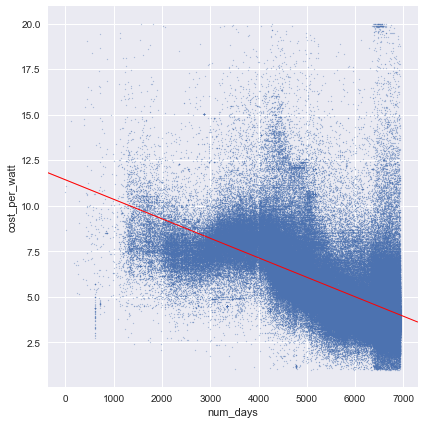

In [9]:
# linear model
sns.lmplot('num_days', 'cost_per_watt', dfMod, 
           size=6, markers='.', 
           scatter_kws={'alpha' : 0.4, 's' : 7},
           line_kws={'color':'red', 'linewidth' : 1});

In [10]:
# # degree 6 polynomial; this takes a while; not recommended unless you go to get some coffee...
# sns.lmplot('num_days', 'cost_per_watt', dfMod, 
#            size=6, markers='.', order=6,
#            scatter_kws={'alpha' : 0.4, 's' : 7},
#            line_kws={'color':'red', 'linewidth' : 1});
# plt.ylim(0.0, 20)

##### Seaborn fits a 6th degree model

![seaborn_6th_fit](./seaborn_6th_fit.png)

#### Set up a sklearn pipeline

In [11]:
# set up to model one feature (column vectors for both X and y)
X = dfMod[['num_days']].values
y = dfMod[['cost_per_watt']].values
X.shape, y.shape

((364212, 1), (364212, 1))

In [12]:
# Setup the pipeline steps
steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures()),
         ('LR', LinearRegression())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

In [13]:
# what's in the pipeline?
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'poly', 'LR', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])

In [14]:
# Specify the hyperparameter space.
# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 20)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the 3-fold GridSearchCV object: gm_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, return_train_score=True)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

Best parameters: {'poly__degree': 18}
test R squared: 0.45455525753760206


In [15]:
# this will show the results data structure
gs_cv.cv_results_

{'mean_fit_time': array([0.0354, 0.0421, 0.0536, 0.0685, 0.0941, 0.1039, 0.1166, 0.142 ,
        0.1594, 0.1786, 0.2034, 0.2279, 0.2632, 0.3239, 0.3295, 0.3429,
        0.3874, 0.4119, 0.428 ]),
 'std_fit_time': array([0.0014, 0.0039, 0.0046, 0.0043, 0.0082, 0.0079, 0.0053, 0.0045,
        0.0057, 0.003 , 0.0041, 0.0031, 0.0102, 0.0267, 0.0159, 0.0099,
        0.0059, 0.0277, 0.0424]),
 'mean_score_time': array([0.0053, 0.0085, 0.0102, 0.0135, 0.0207, 0.0221, 0.0256, 0.0336,
        0.0368, 0.0455, 0.0568, 0.0588, 0.0729, 0.0827, 0.0949, 0.1051,
        0.1268, 0.1253, 0.1293]),
 'std_score_time': array([0.0002, 0.0007, 0.0002, 0.0032, 0.002 , 0.0007, 0.0011, 0.0032,
        0.0002, 0.0002, 0.0031, 0.0006, 0.004 , 0.0019, 0.0053, 0.0041,
        0.0046, 0.0064, 0.0068]),
 'param_poly__degree': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17, 18, 19],
              mask=[False, False, False, False, False, False, False, False,
            

#### The pipeline above is working.  Next step is to add a scorer that produces multiple scores. 

#### Instead of defining your own scorer to track multiple metrics, you can hand gridsearchcv a list of scoring fns to use (but you can only use the ones sklearn blesses).   The other option is to pass a dictionary of names and fns.

In [16]:
# we want to search and plot separately

# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 21)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'poly__degree': 18}
test R squared: 0.4532136546525959


### Plot the best model that GridSearchCV finds

Best parameters: {'poly__degree': 18}
Best R squared: 0.45455525753760206


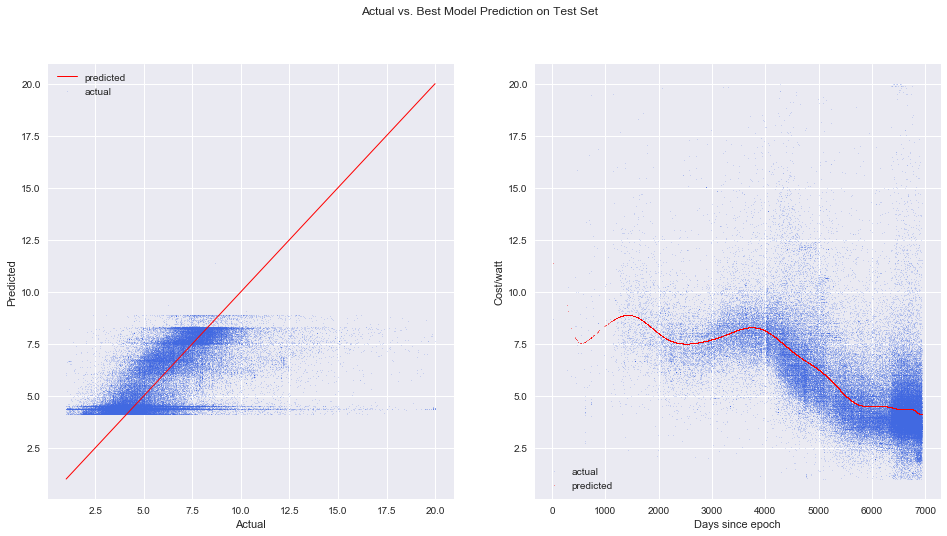

In [17]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=2, color='royalblue', alpha=0.2, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=2, alpha=0.2, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=2, alpha=0.4, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('Days since epoch')
ax2.legend()

plt.show();

### Now plot train/test errors vs. complexity


In [18]:
def trainVsTestResults(results): 
    ''' Plot test/train results for R^2 and RMSE'''    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=1.0, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best R squared: {}".format(r2))

Best parameters: {'poly__degree': 18}
Best R squared: 0.4532136546525959


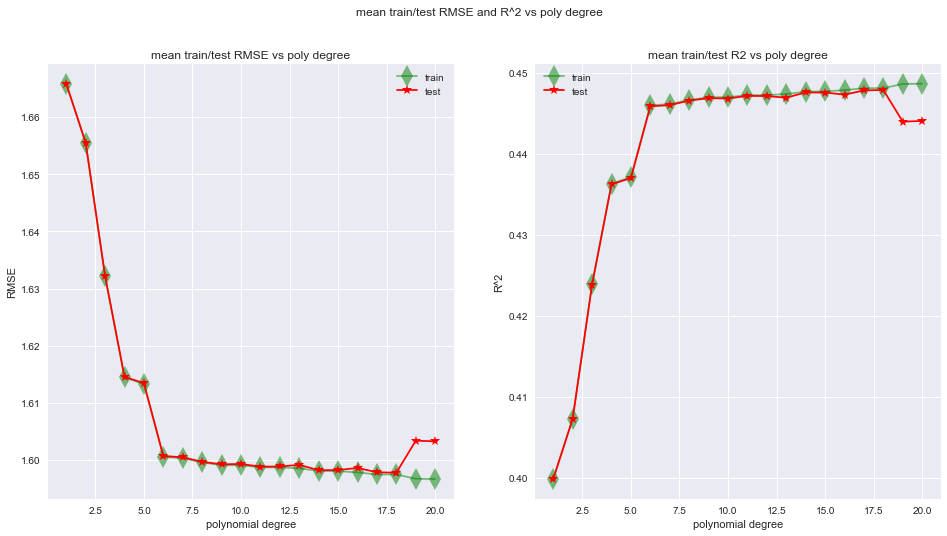

In [19]:
trainVsTestResults(gs_cv.cv_results_)